In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import tlmdKANLayer, tlmdKAN, importance_analyse_tlmdKAN#, shap_analysis, grad_analysis, get_df4bar


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


-----
-----
## $f_1(x_1, x_2)$

##### $f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


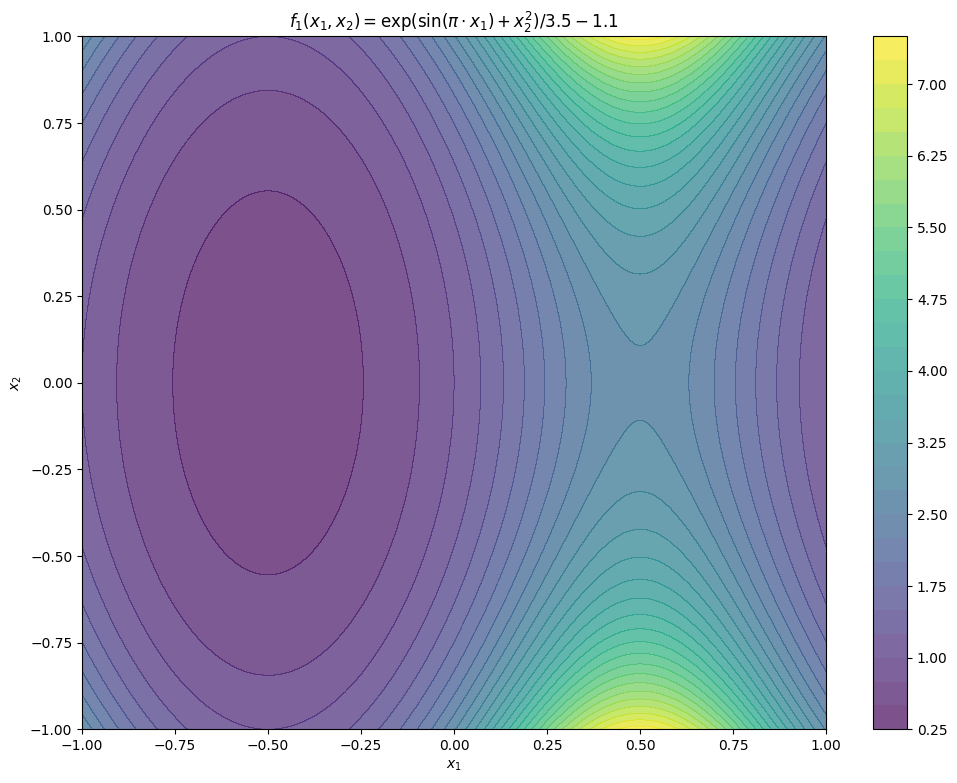

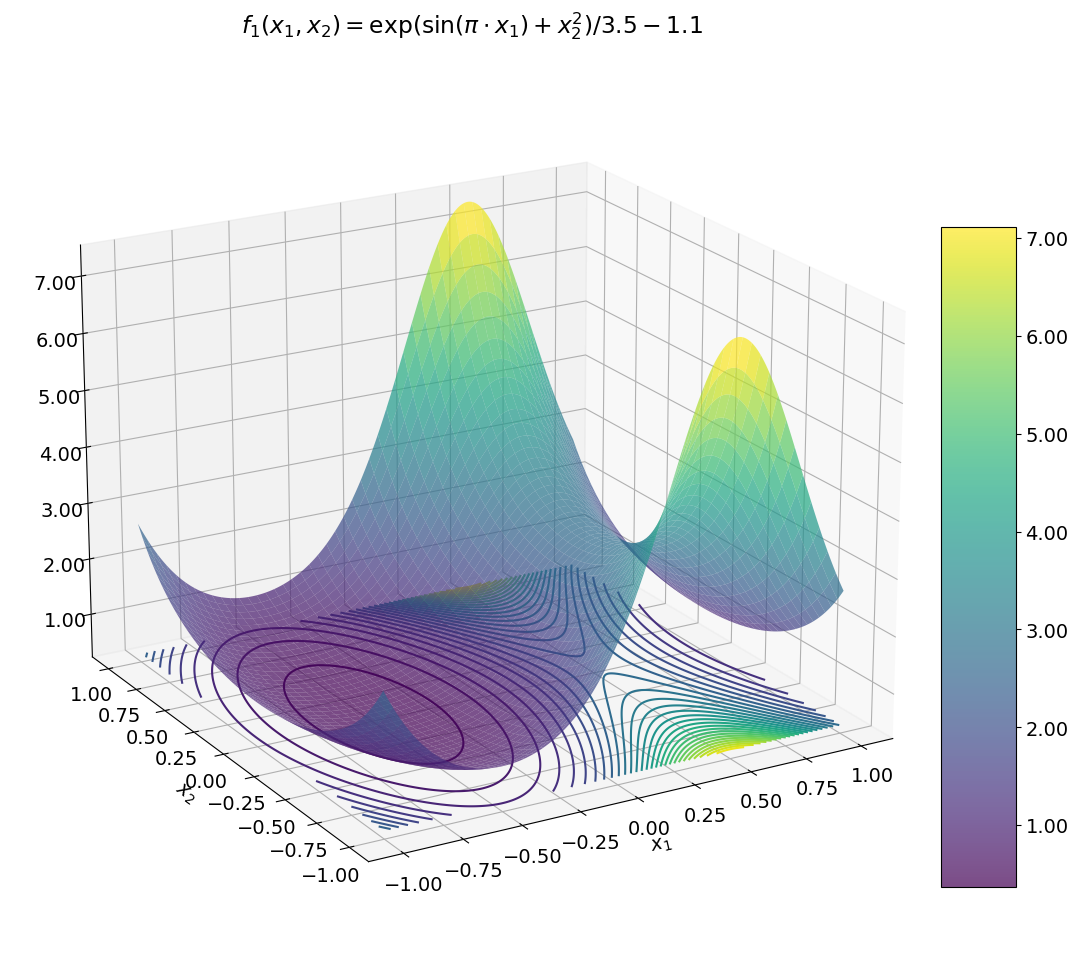

In [2]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=2, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 216


| train_loss: 2.18e-02 | test_loss: 2.91e-02 | reg: 1.07e+02 | : 100%|█| 100/100 [00:06<00:00, 14.70


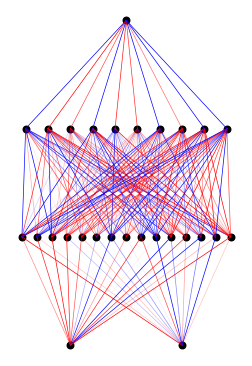

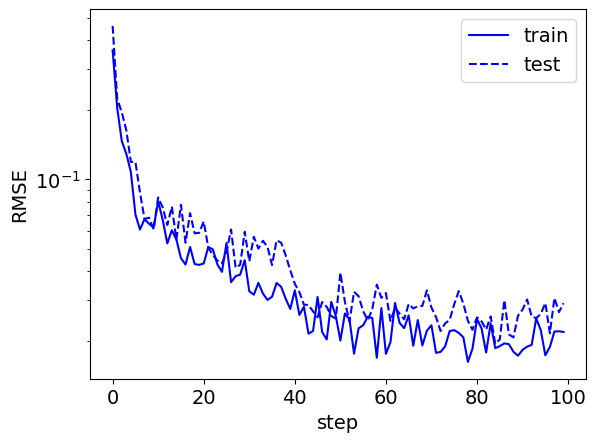

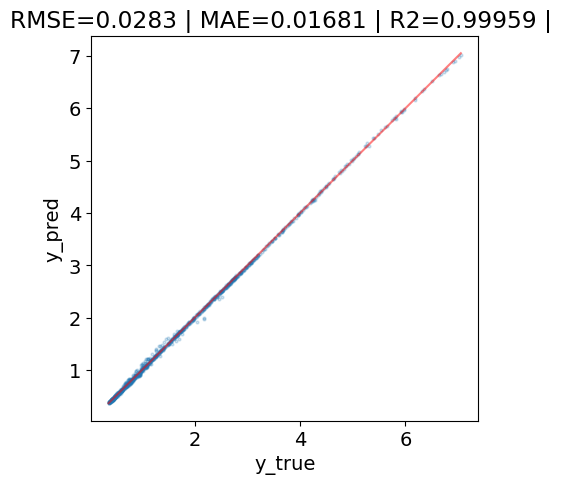

In [29]:
# initialize MLP
model = MLP(width=[2,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

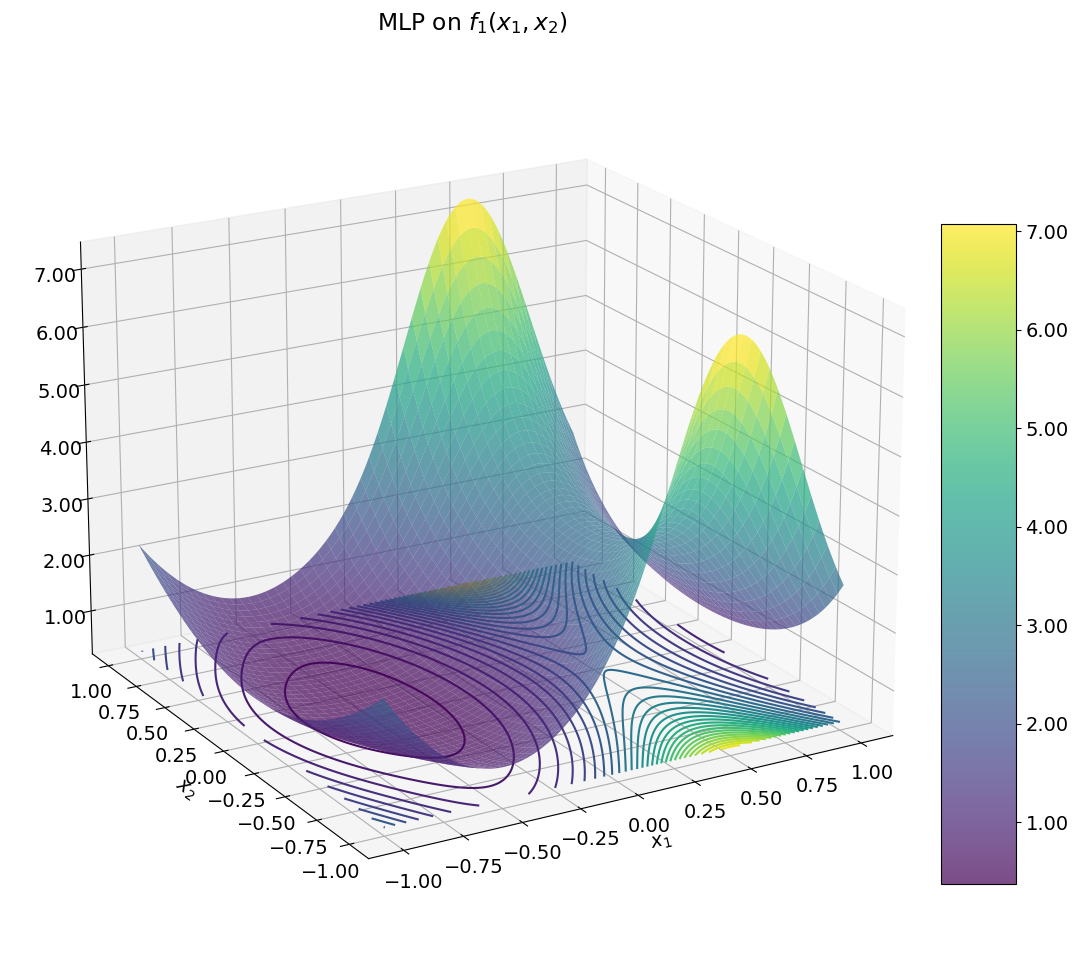

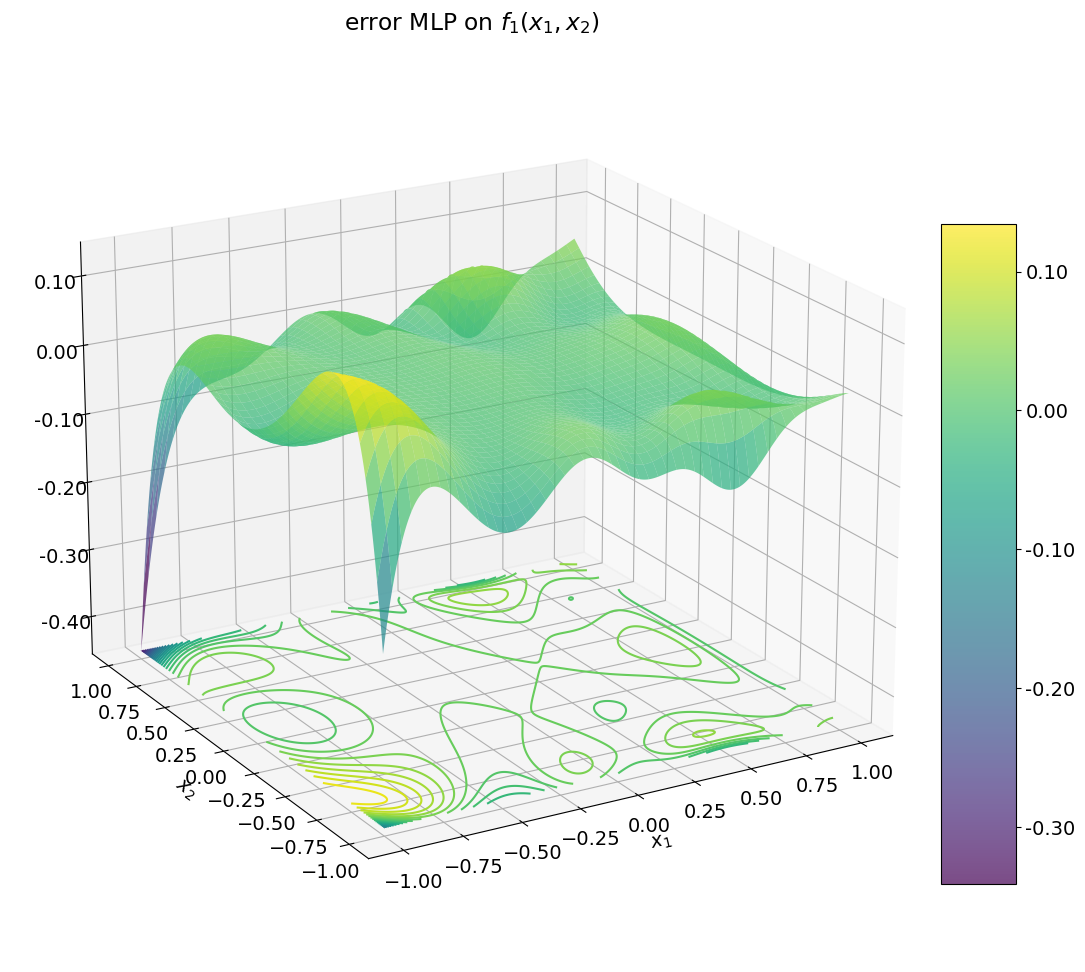

In [30]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='MLP on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error MLP on $f_1(x_1, x_2)$')

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 180


| train_loss: 6.24e-03 | test_loss: 6.00e-03 | reg: 1.56e+01 | : 100%|█| 100/100 [00:43<00:00,  2.27


saving model version 0.1


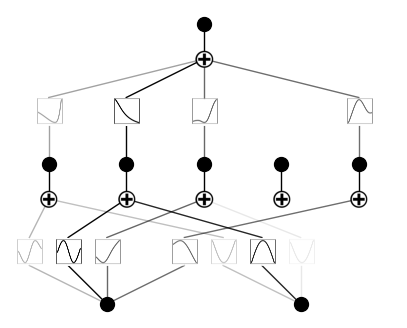

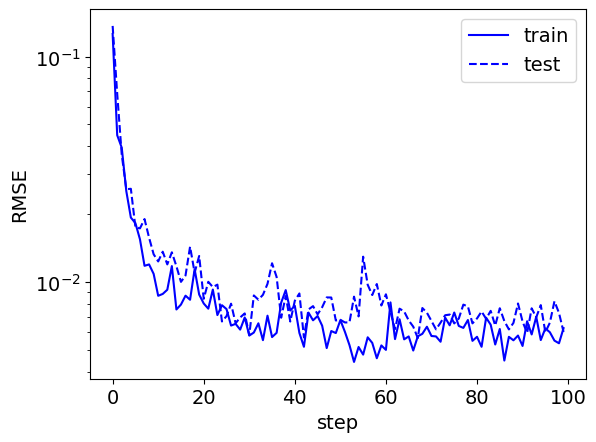

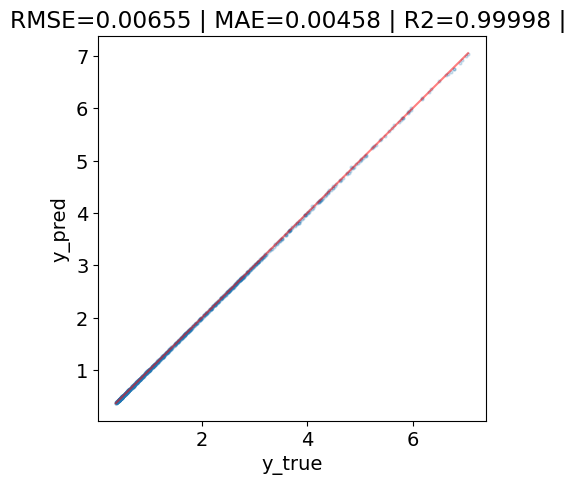

In [31]:
# initialize KAN with G=3
model = KAN(width=[2,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

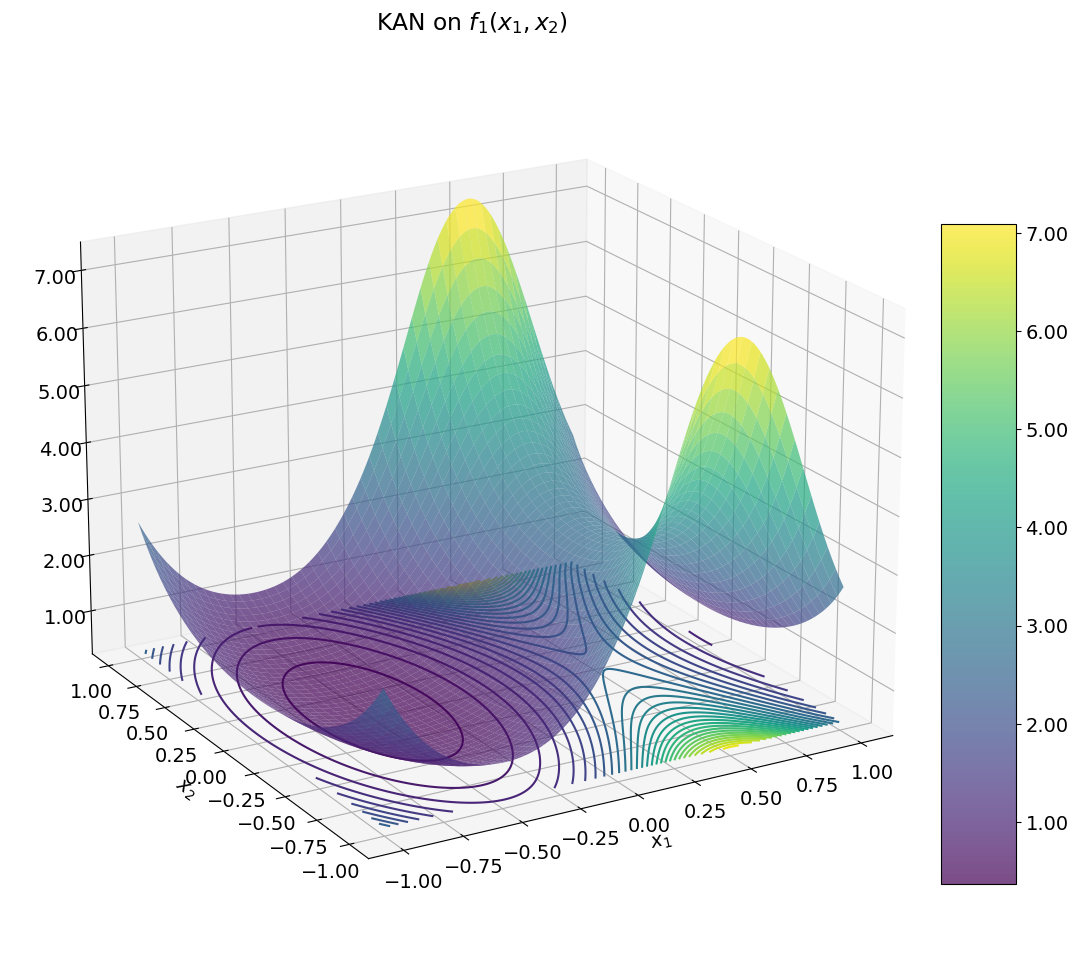

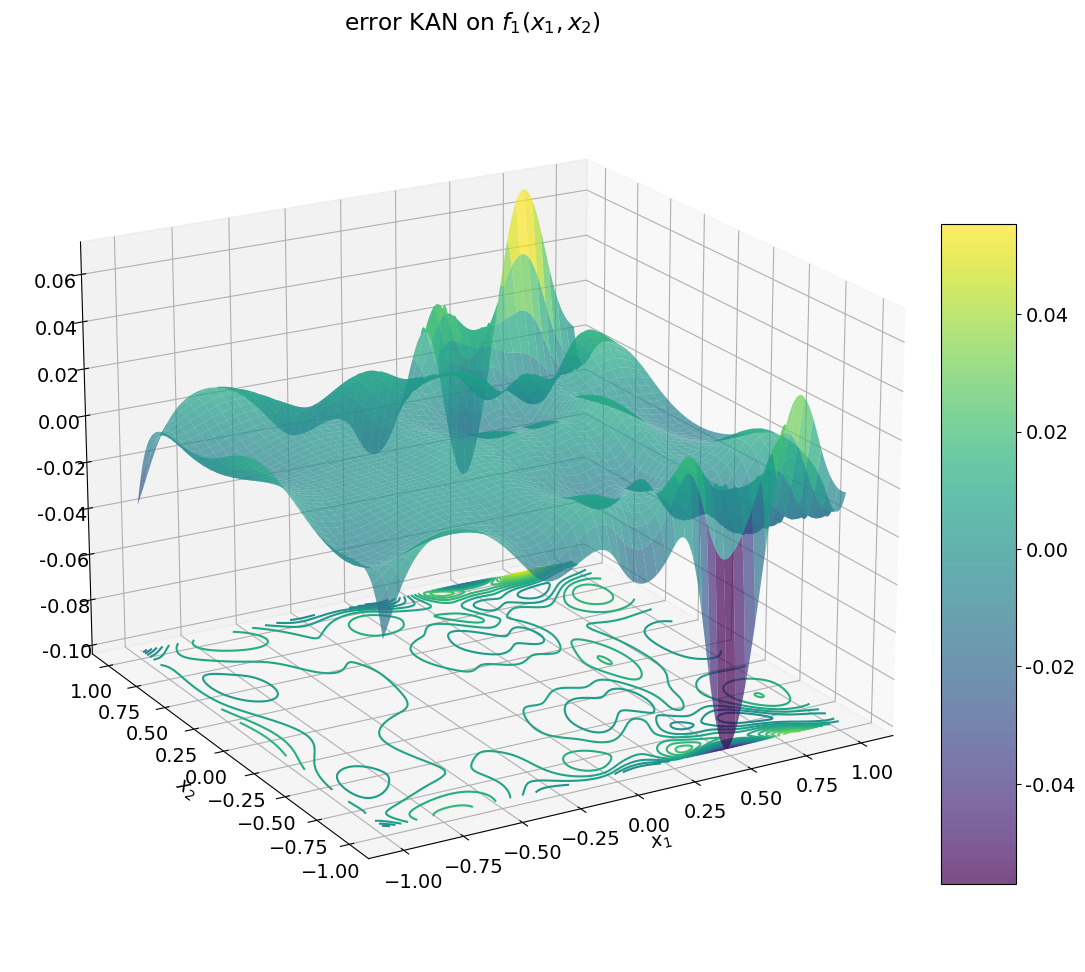

In [32]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$
tlmd_alpha=1e-1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 286


| train_loss: 1.29e-02 | test_loss: 1.81e-02 | reg: 1.78e+01 | : 100%|█| 150/150 [01:19<00:00,  1.88


saving model version 0.1


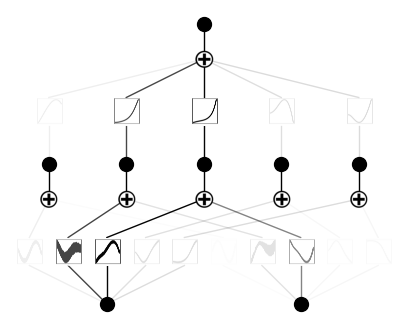

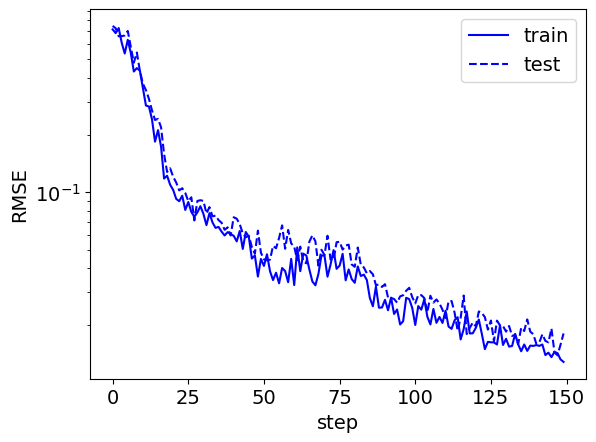

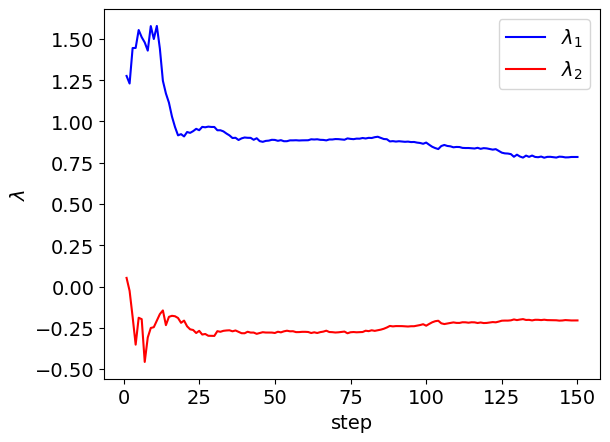

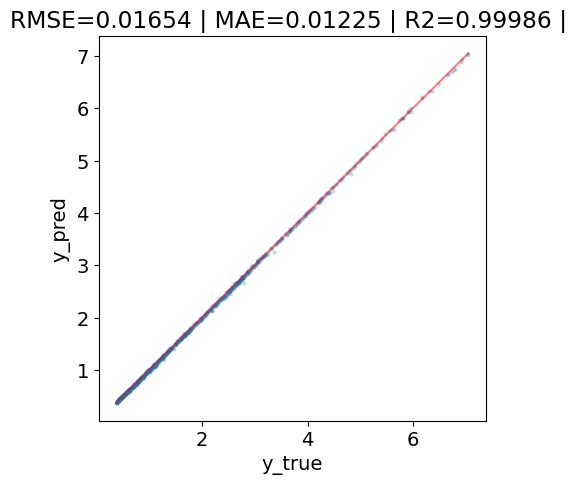

model.act_fun[0].lmd=Parameter containing:
tensor([ 0.7845, -0.2053], requires_grad=True)


In [3]:
# initialize lmdKAN with G=3
model = tlmdKAN(width=[2,5,1], grid=3, k=3, seed=2, device=device, tlmd_type='kan', tlmd_width=[3], lmd_init_vector=[1,1], tlmd_alpha=1e-1)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

In [4]:
model.act_fun[0].lmd

Parameter containing:
tensor([ 0.7845, -0.2053], requires_grad=True)

ExactExplainer explainer: 1001it [00:27, 26.17it/s]                          


module of Input importance:


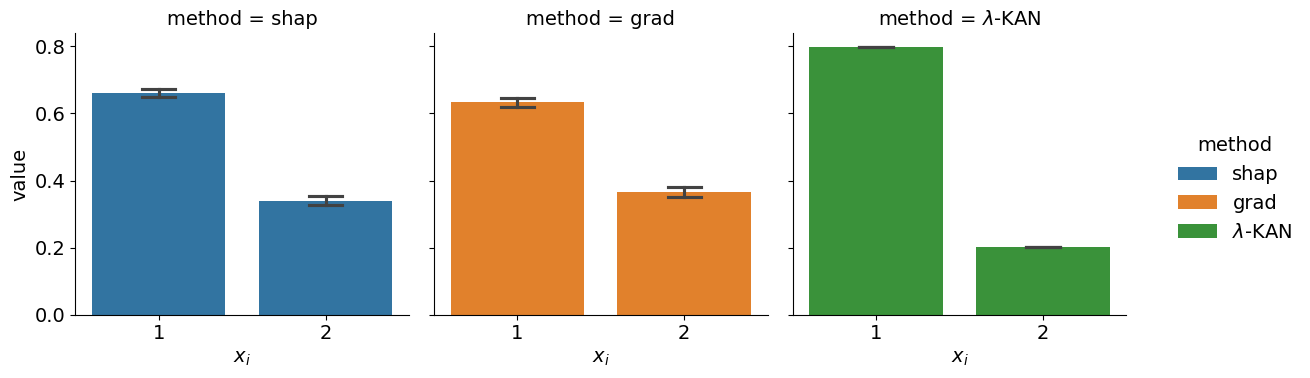

Input importance:


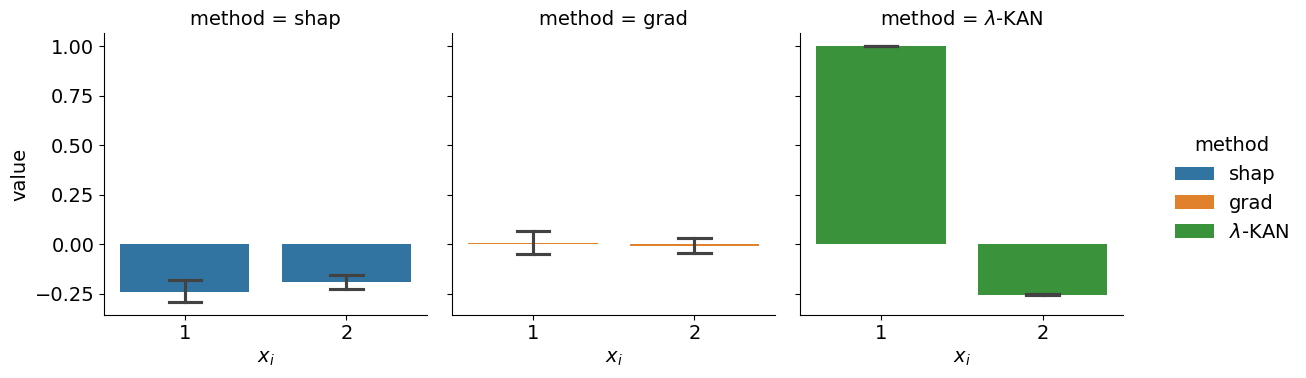

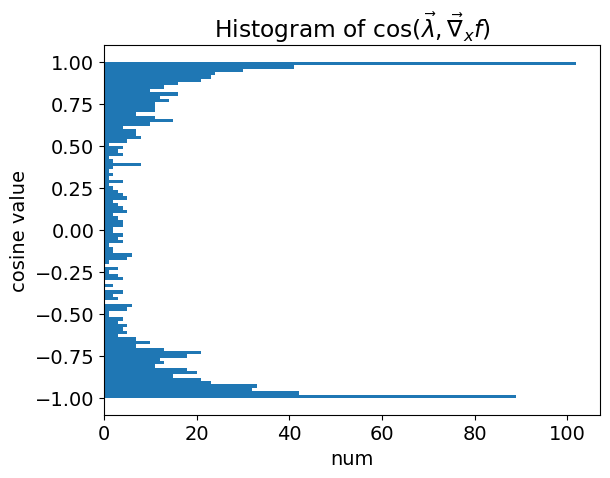

In [5]:
importance_analyse_tlmdKAN(model, dataset)

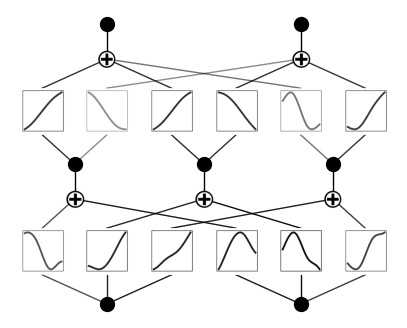

In [6]:
model.act_fun[0].tlmd_model.plot()

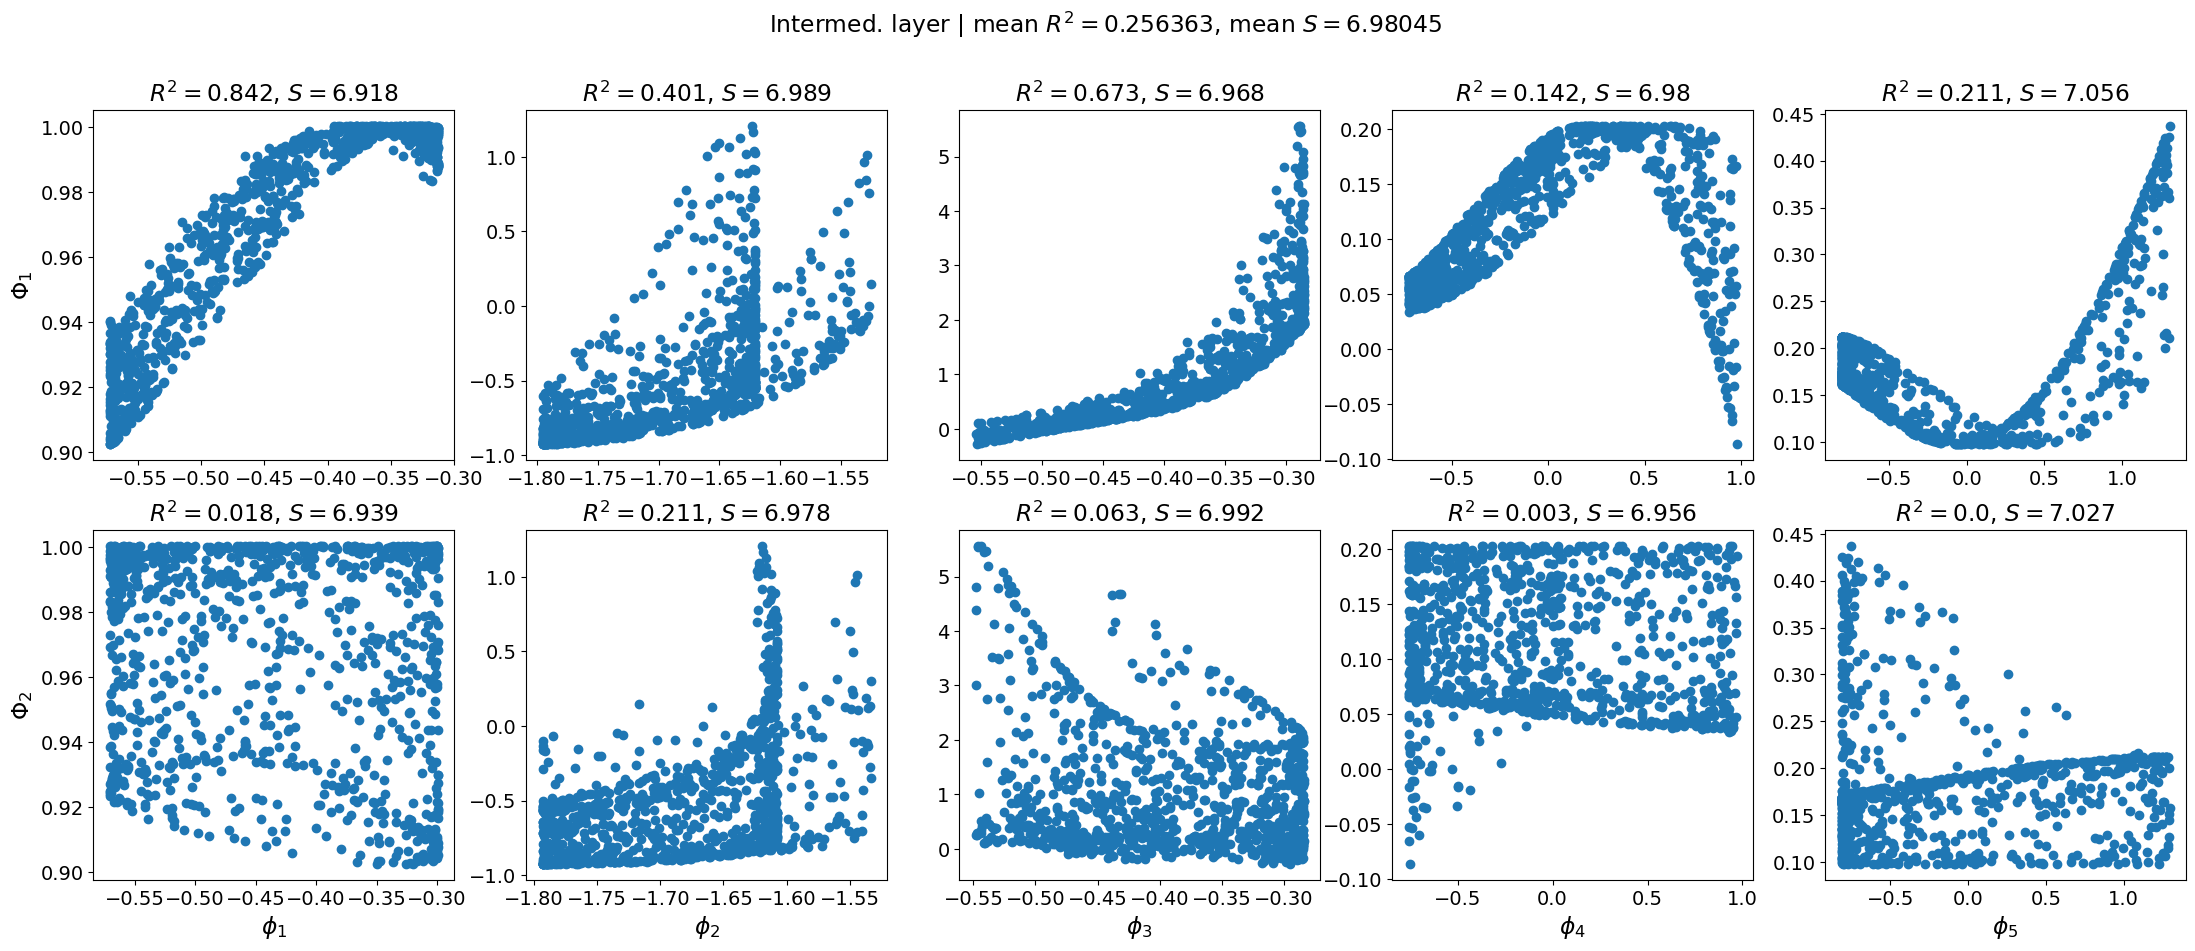

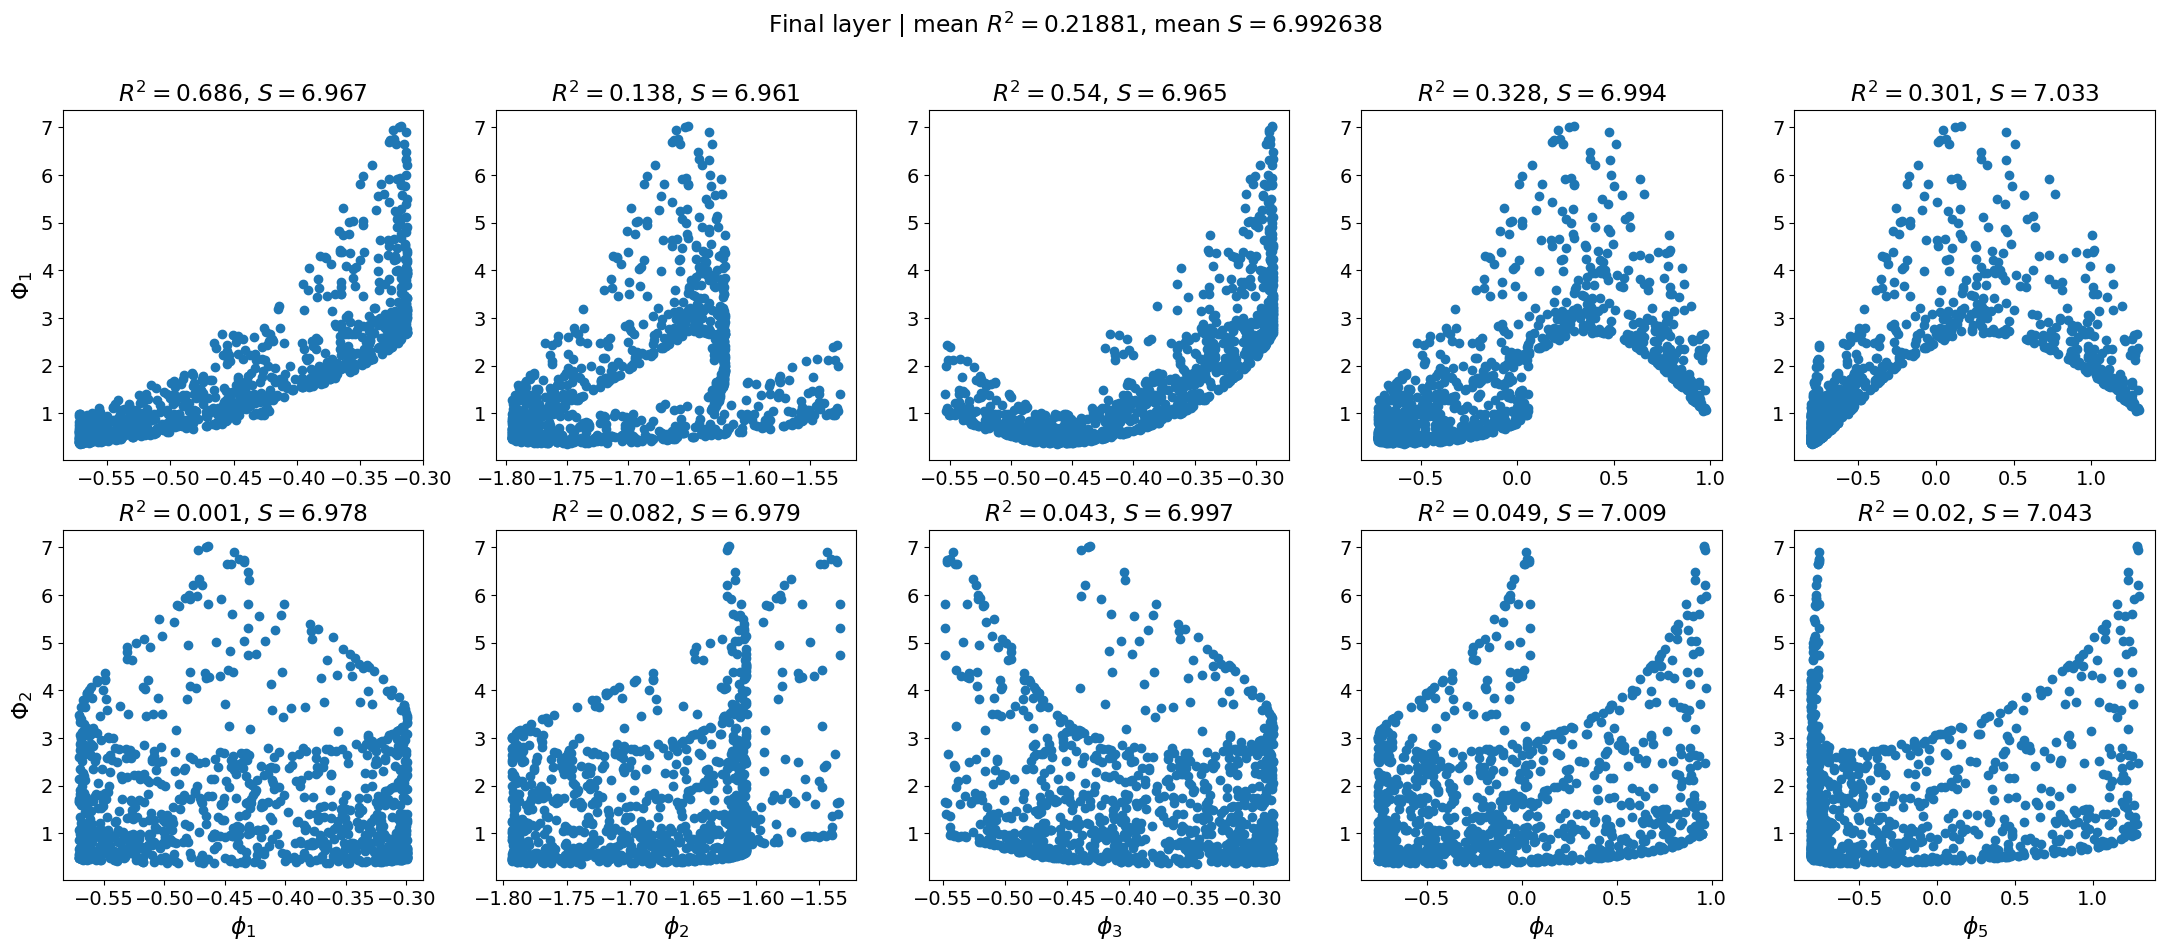

{'mean_r2': 0.2188103706052061, 'mean_matrix_entropy': 6.992637634277344}

In [7]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

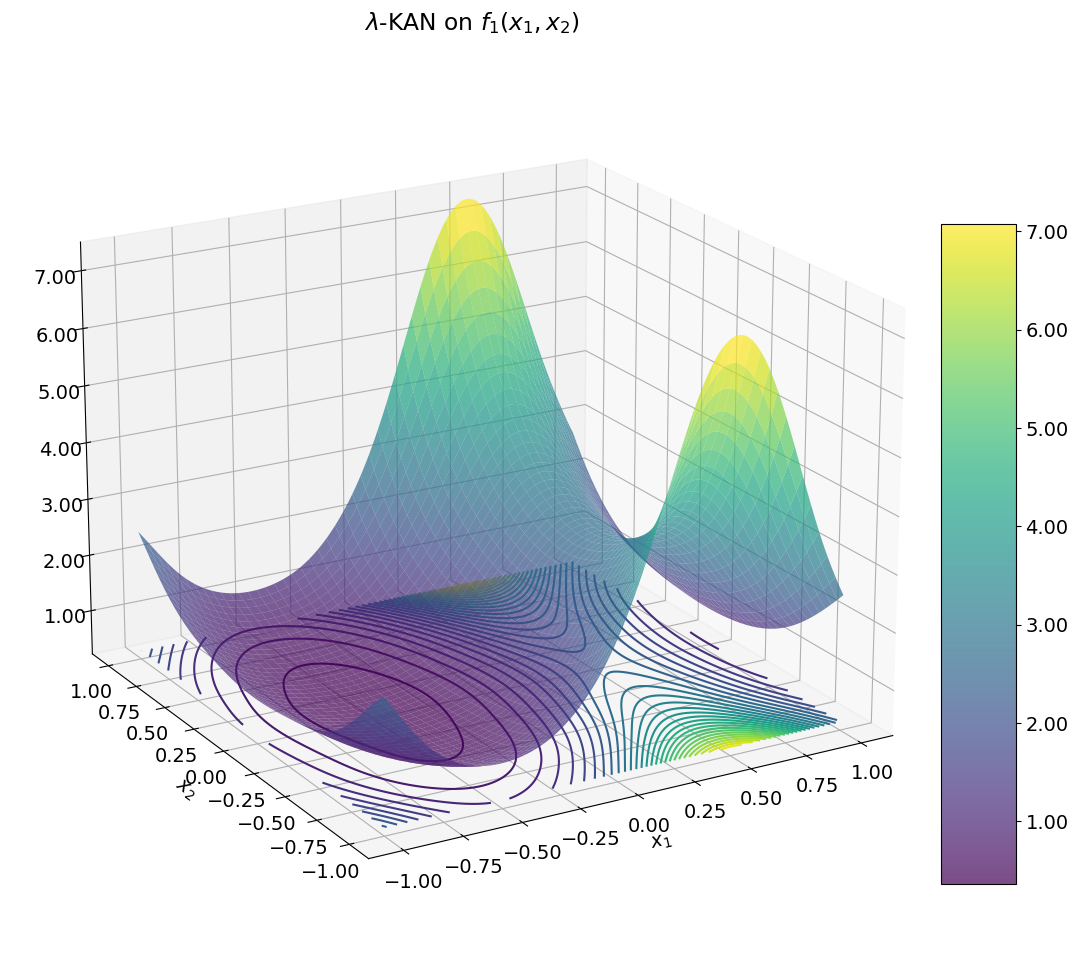

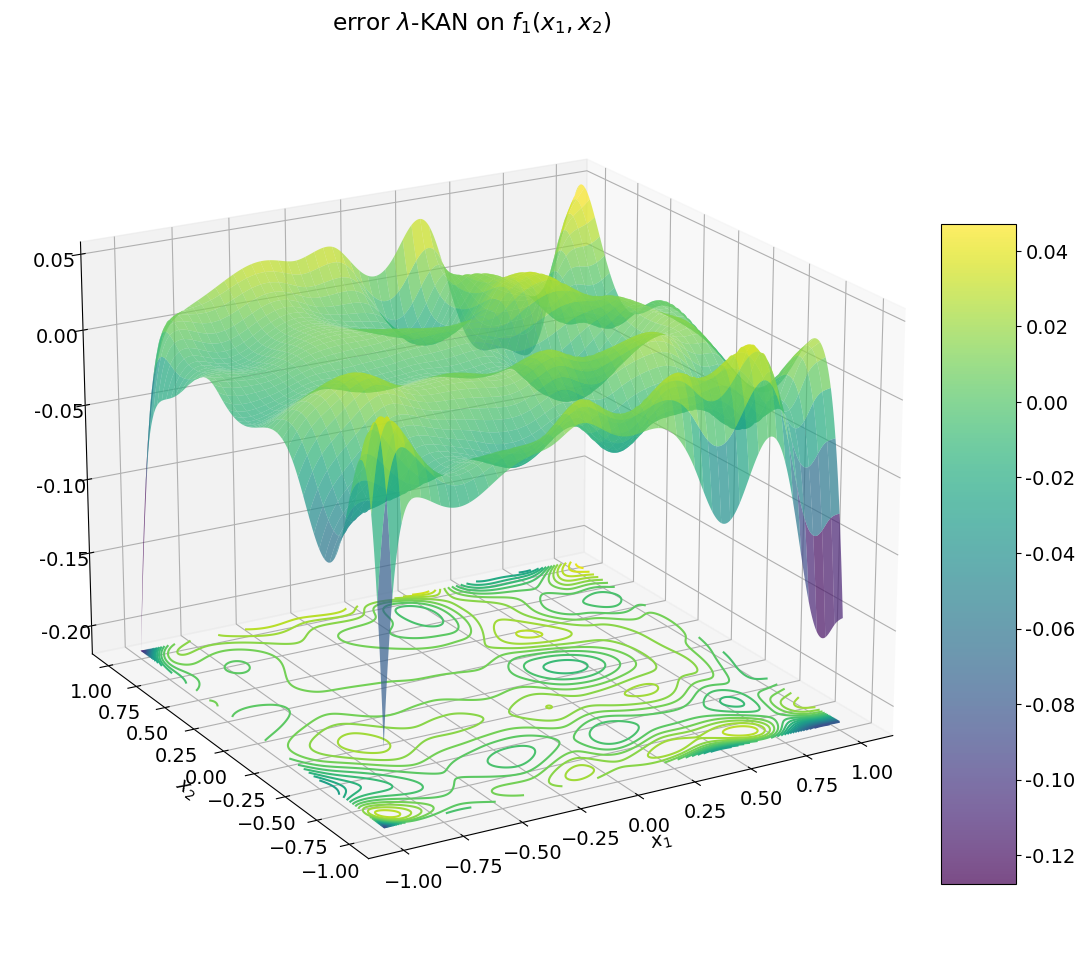

In [8]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$ 
tlmd_alpha=1e-2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 286


| train_loss: 2.33e-01 | test_loss: 2.57e-01 | reg: 3.04e+01 | : 100%|█| 150/150 [01:26<00:00,  1.73


saving model version 0.1


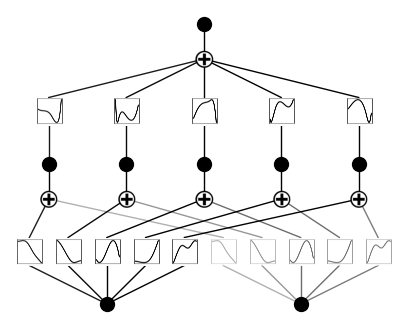

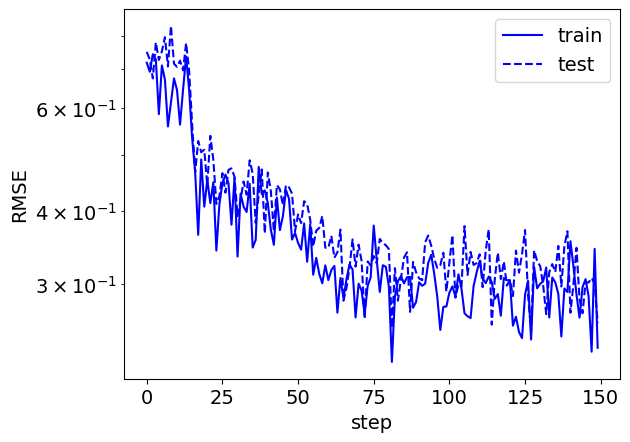

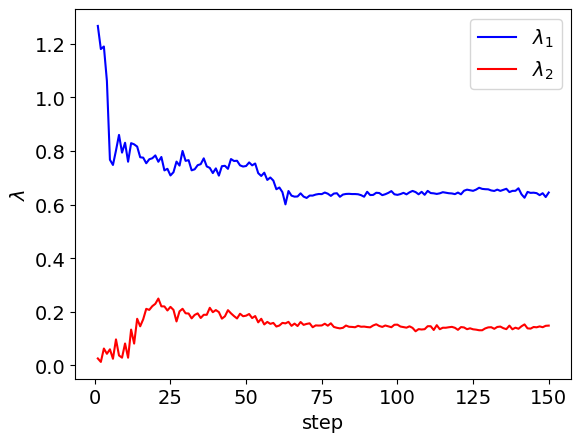

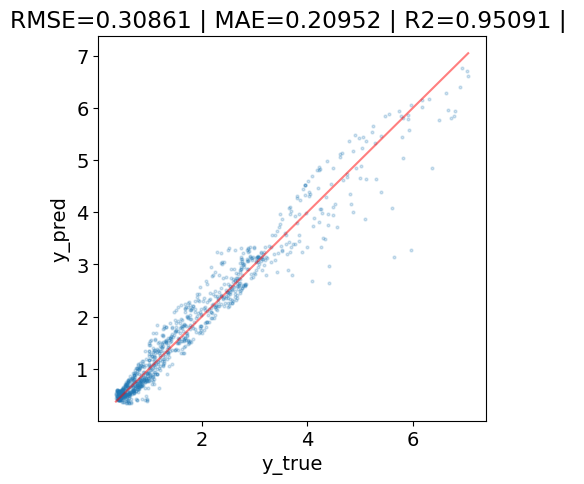

model.act_fun[0].lmd=Parameter containing:
tensor([0.6449, 0.1482], requires_grad=True)


In [15]:
# initialize lmdKAN with G=3
model = tlmdKAN(width=[2,5,1], grid=3, k=3, seed=2, device=device, tlmd_type='kan', tlmd_width=[3], lmd_init_vector=[1,1], tlmd_alpha=1e-2)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

In [16]:
model.act_fun[0].lmd

Parameter containing:
tensor([0.6449, 0.1482], requires_grad=True)

ExactExplainer explainer: 1001it [00:30, 21.23it/s]                         


module of Input importance:


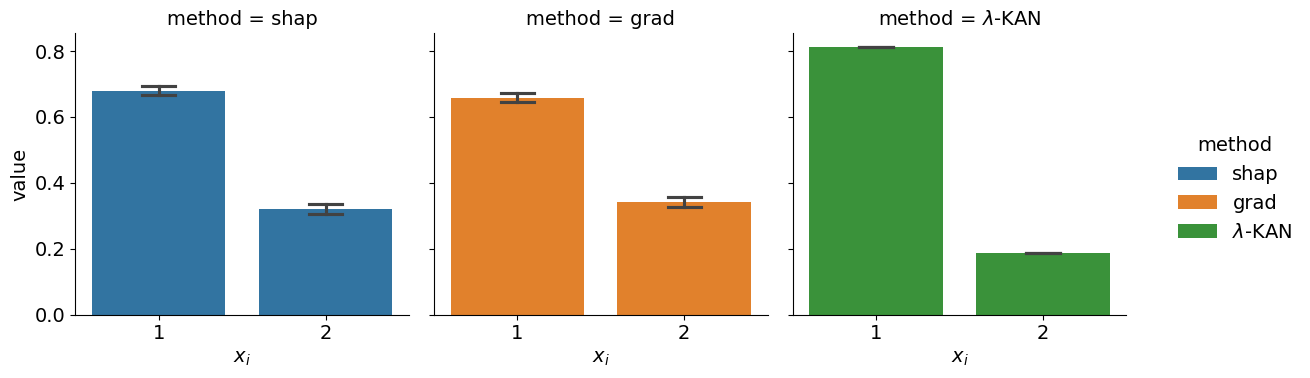

Input importance:


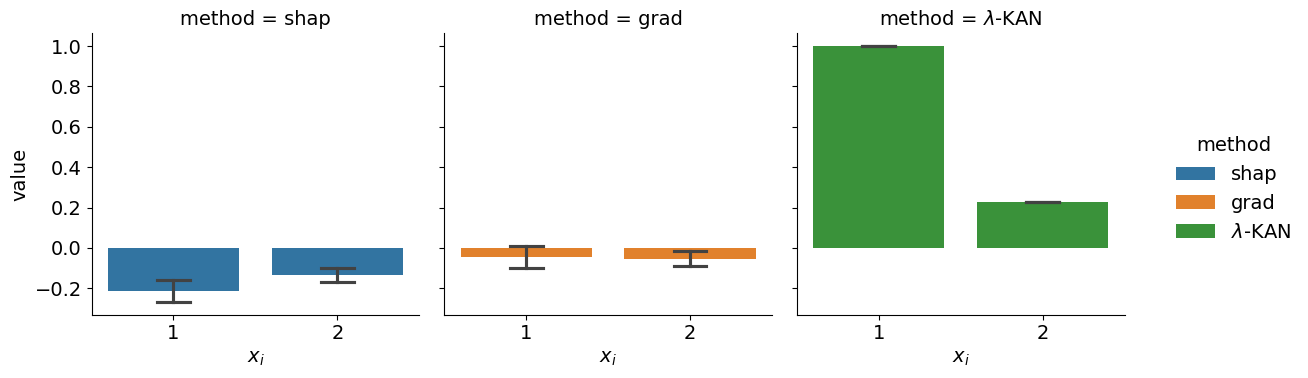

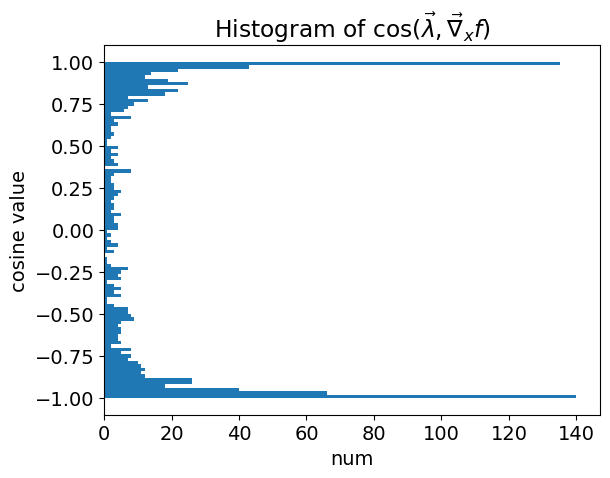

In [17]:
importance_analyse_tlmdKAN(model, dataset)

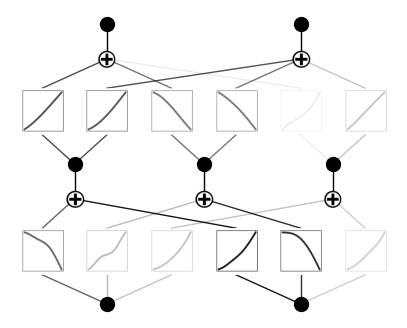

In [18]:
model.act_fun[0].tlmd_model.plot()

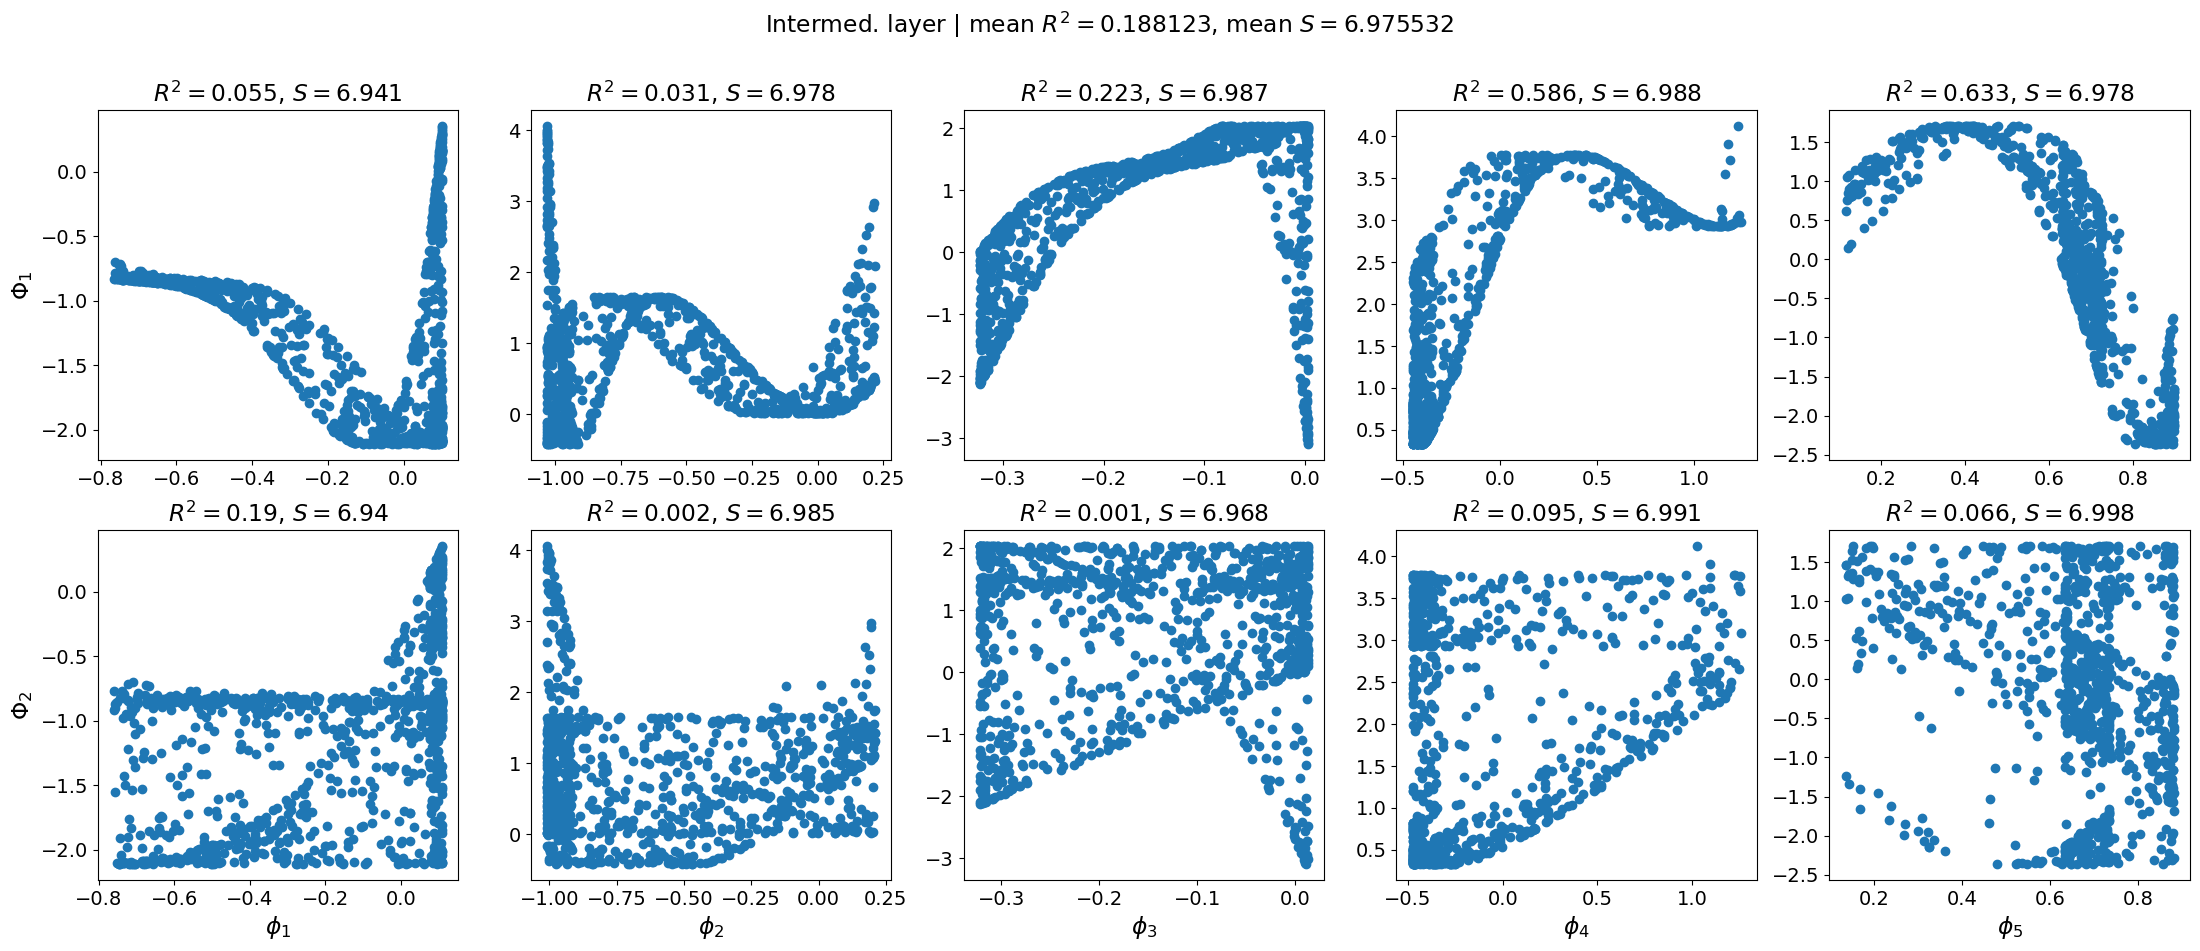

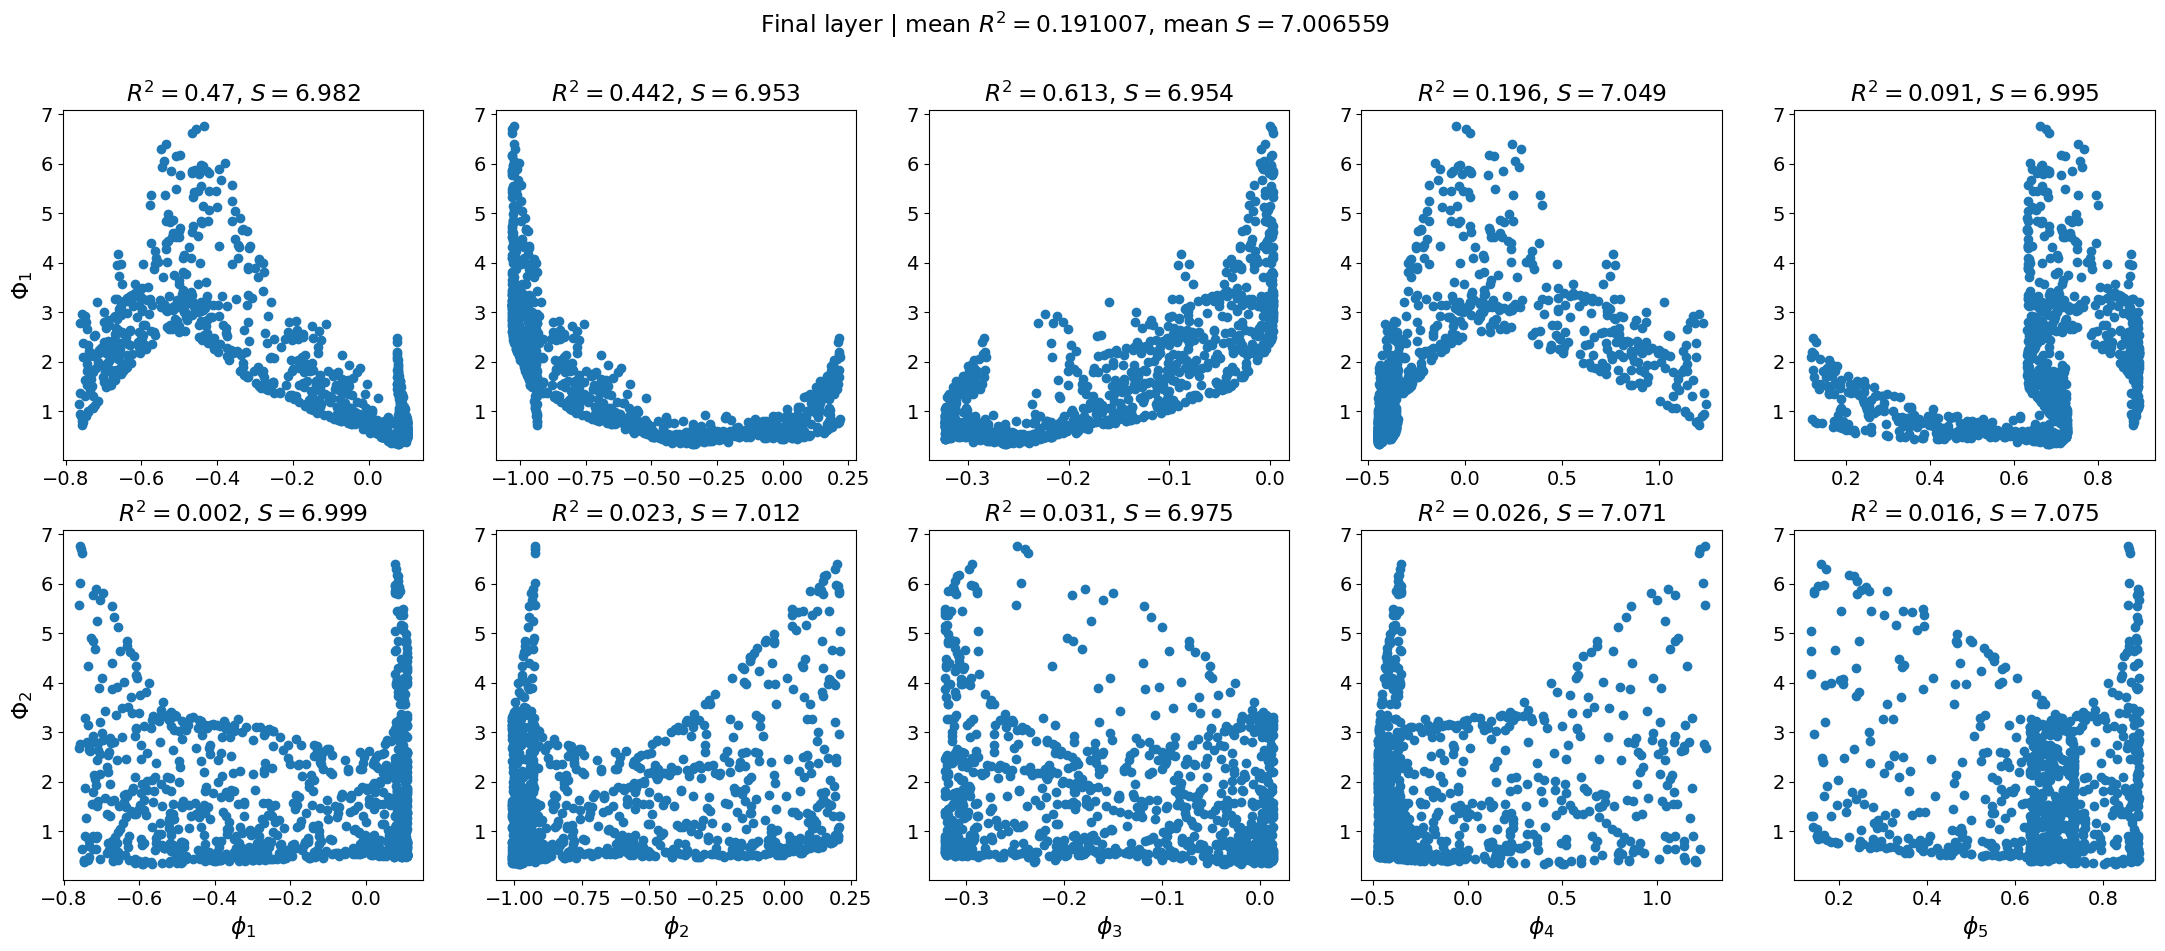

{'mean_r2': 0.1910071661695838, 'mean_matrix_entropy': 7.006558895111084}

In [19]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

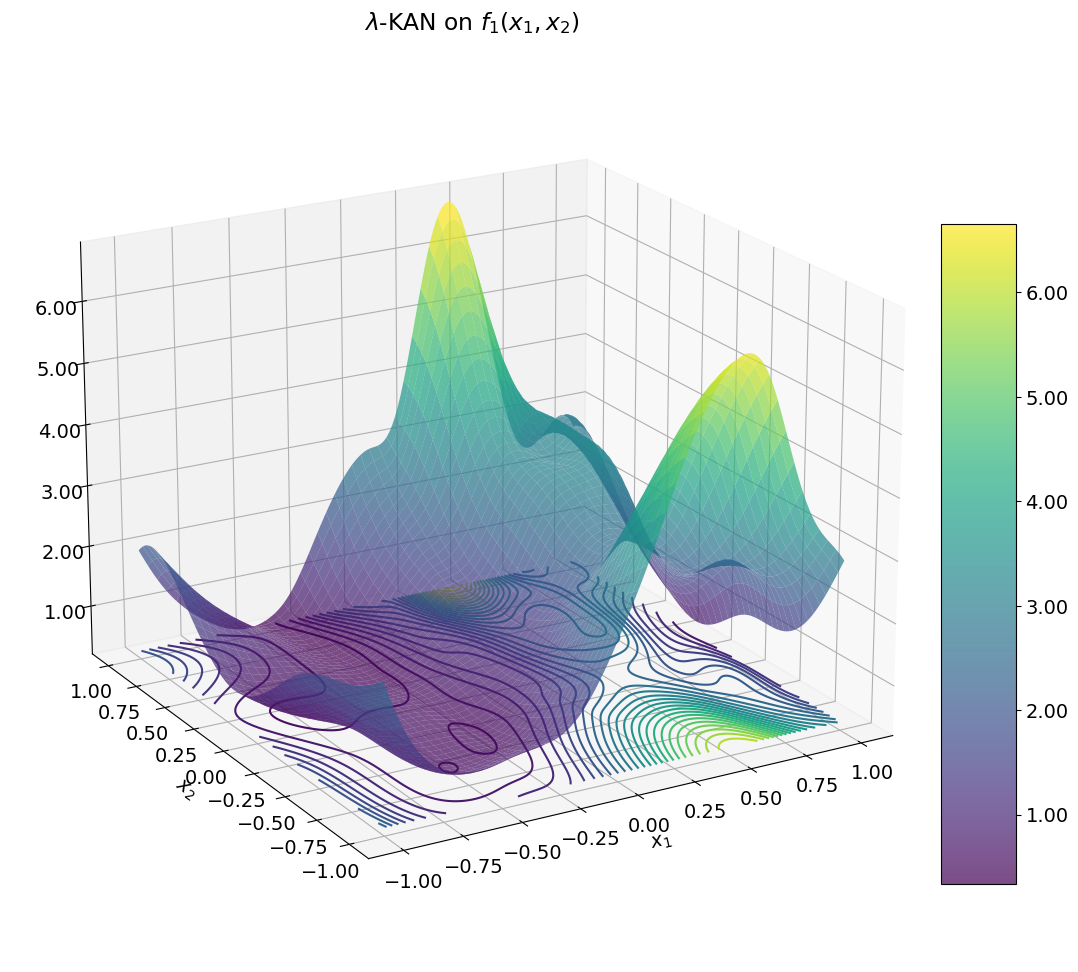

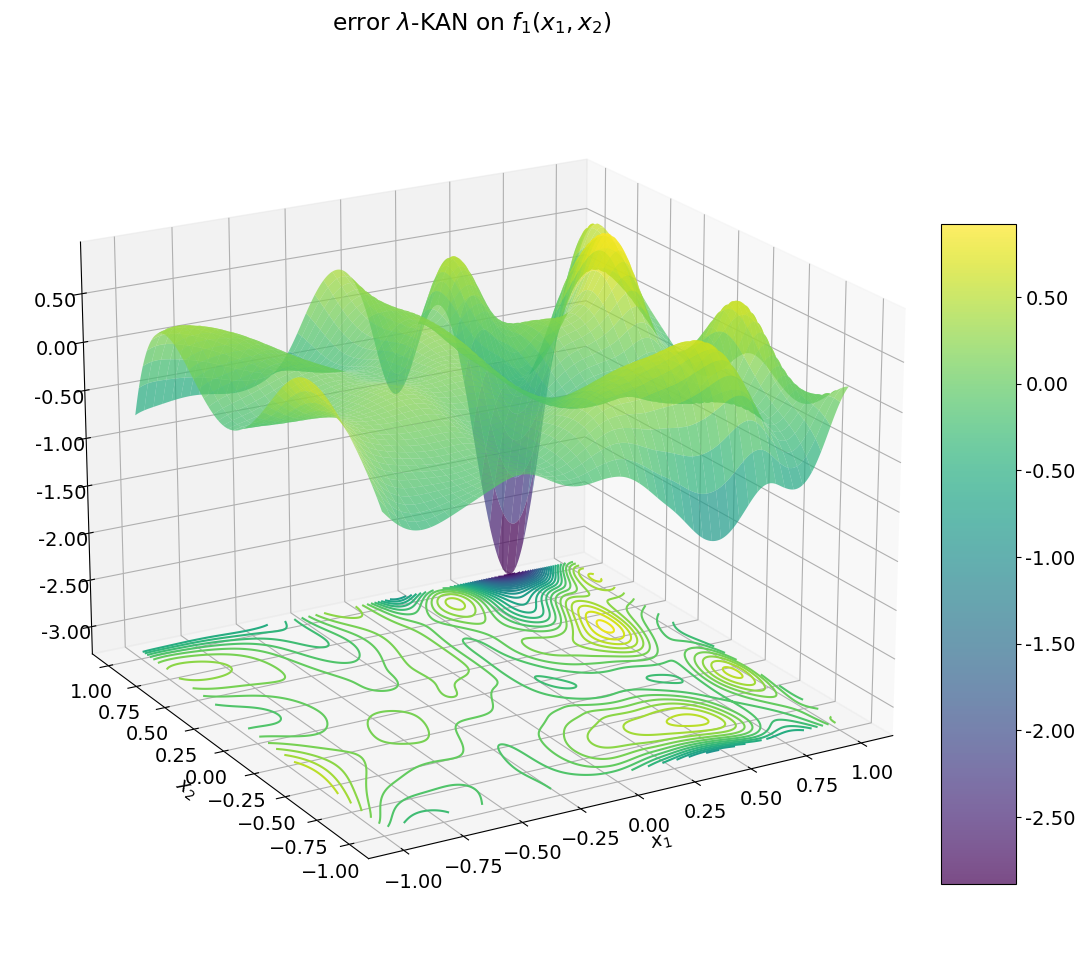

In [20]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')

-----
### $\lambda$-KAN on $f_1$ 
tlmd_alpha=1e-3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 286


| train_loss: 2.58e-01 | test_loss: 2.93e-01 | reg: 2.77e+01 | : 100%|█| 150/150 [01:34<00:00,  1.59


saving model version 0.1


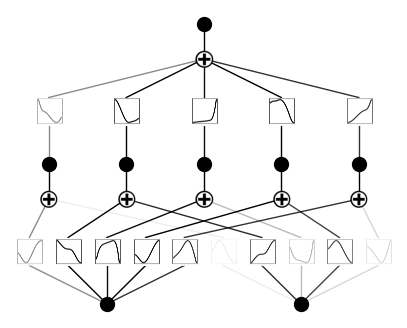

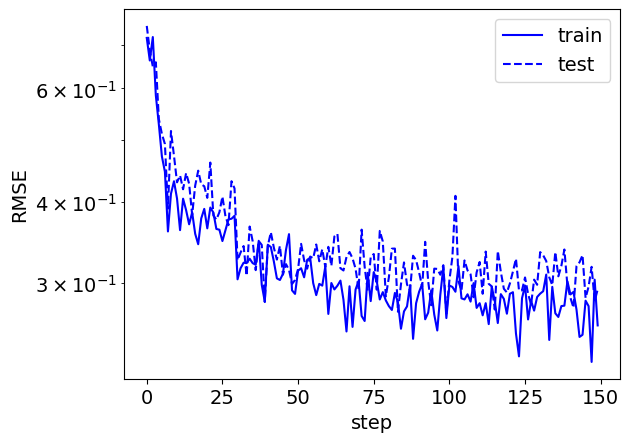

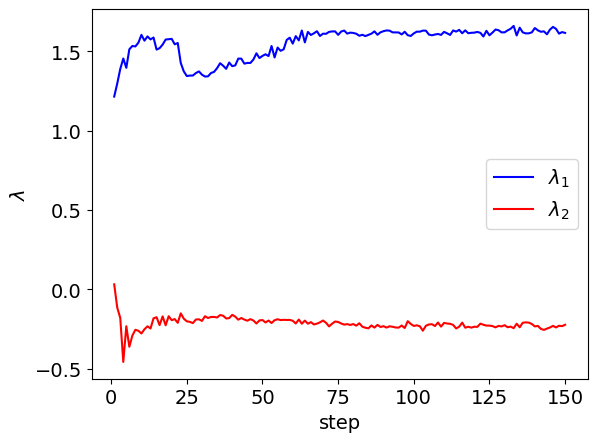

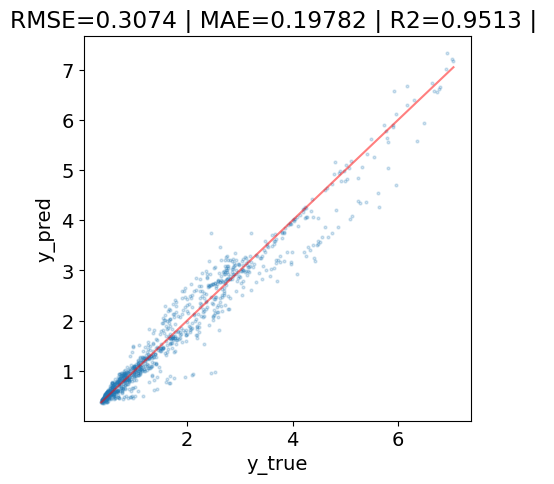

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.6160, -0.2229], requires_grad=True)


In [21]:
# initialize lmdKAN with G=3
model = tlmdKAN(width=[2,5,1], grid=3, k=3, seed=2, device=device, tlmd_type='kan', tlmd_width=[3], lmd_init_vector=[1,1], tlmd_alpha=1e-3)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

In [22]:
model.act_fun[0].lmd

Parameter containing:
tensor([ 1.6160, -0.2229], requires_grad=True)

ExactExplainer explainer: 1001it [00:29, 21.40it/s]                          


module of Input importance:


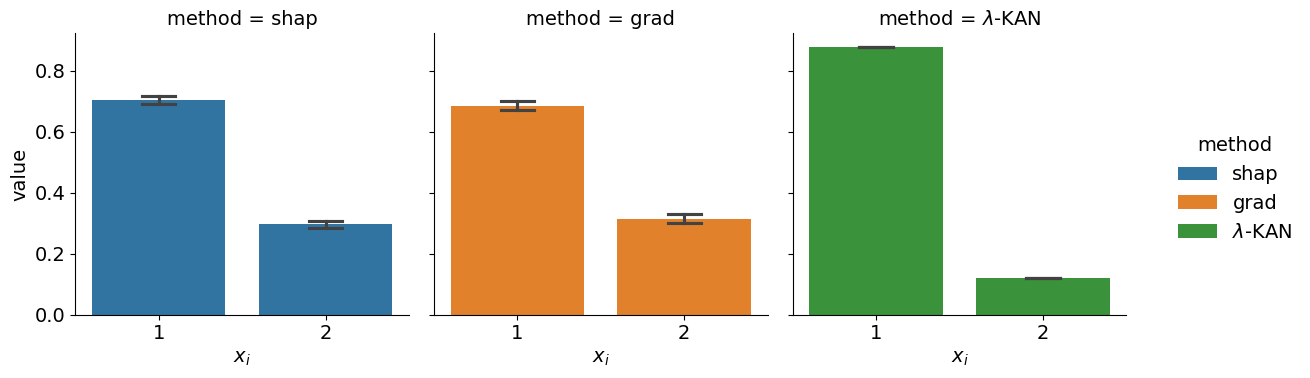

Input importance:


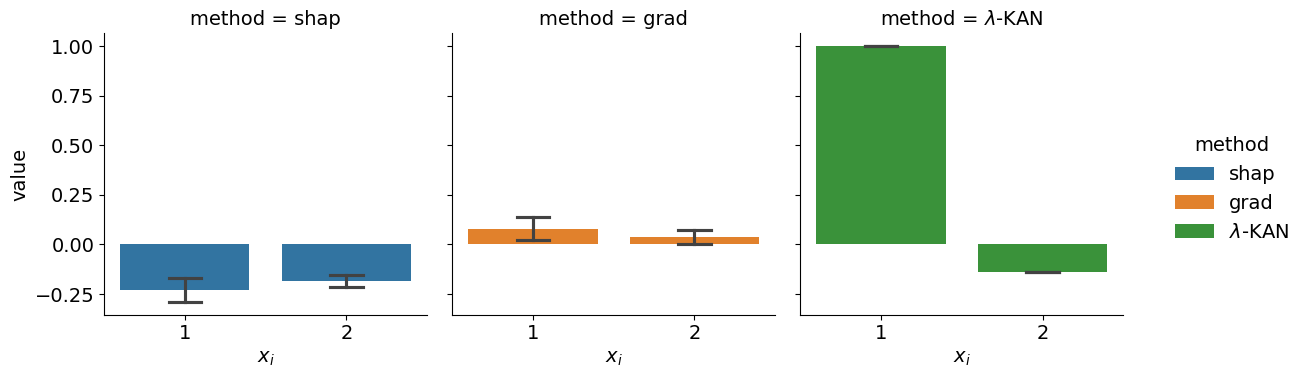

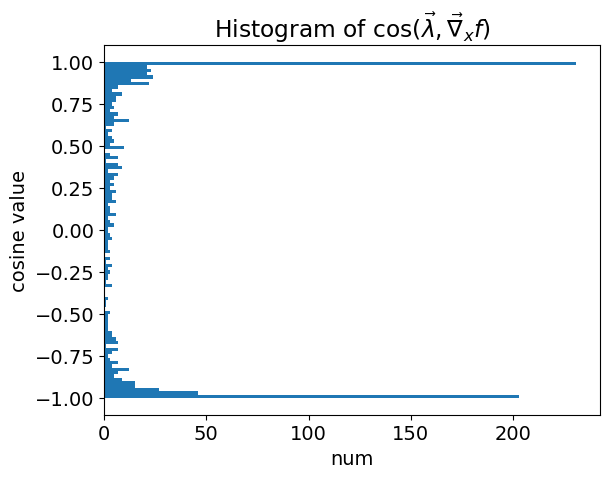

In [23]:
importance_analyse_tlmdKAN(model, dataset)

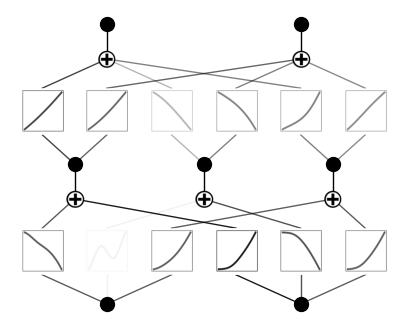

In [24]:
model.act_fun[0].tlmd_model.plot()

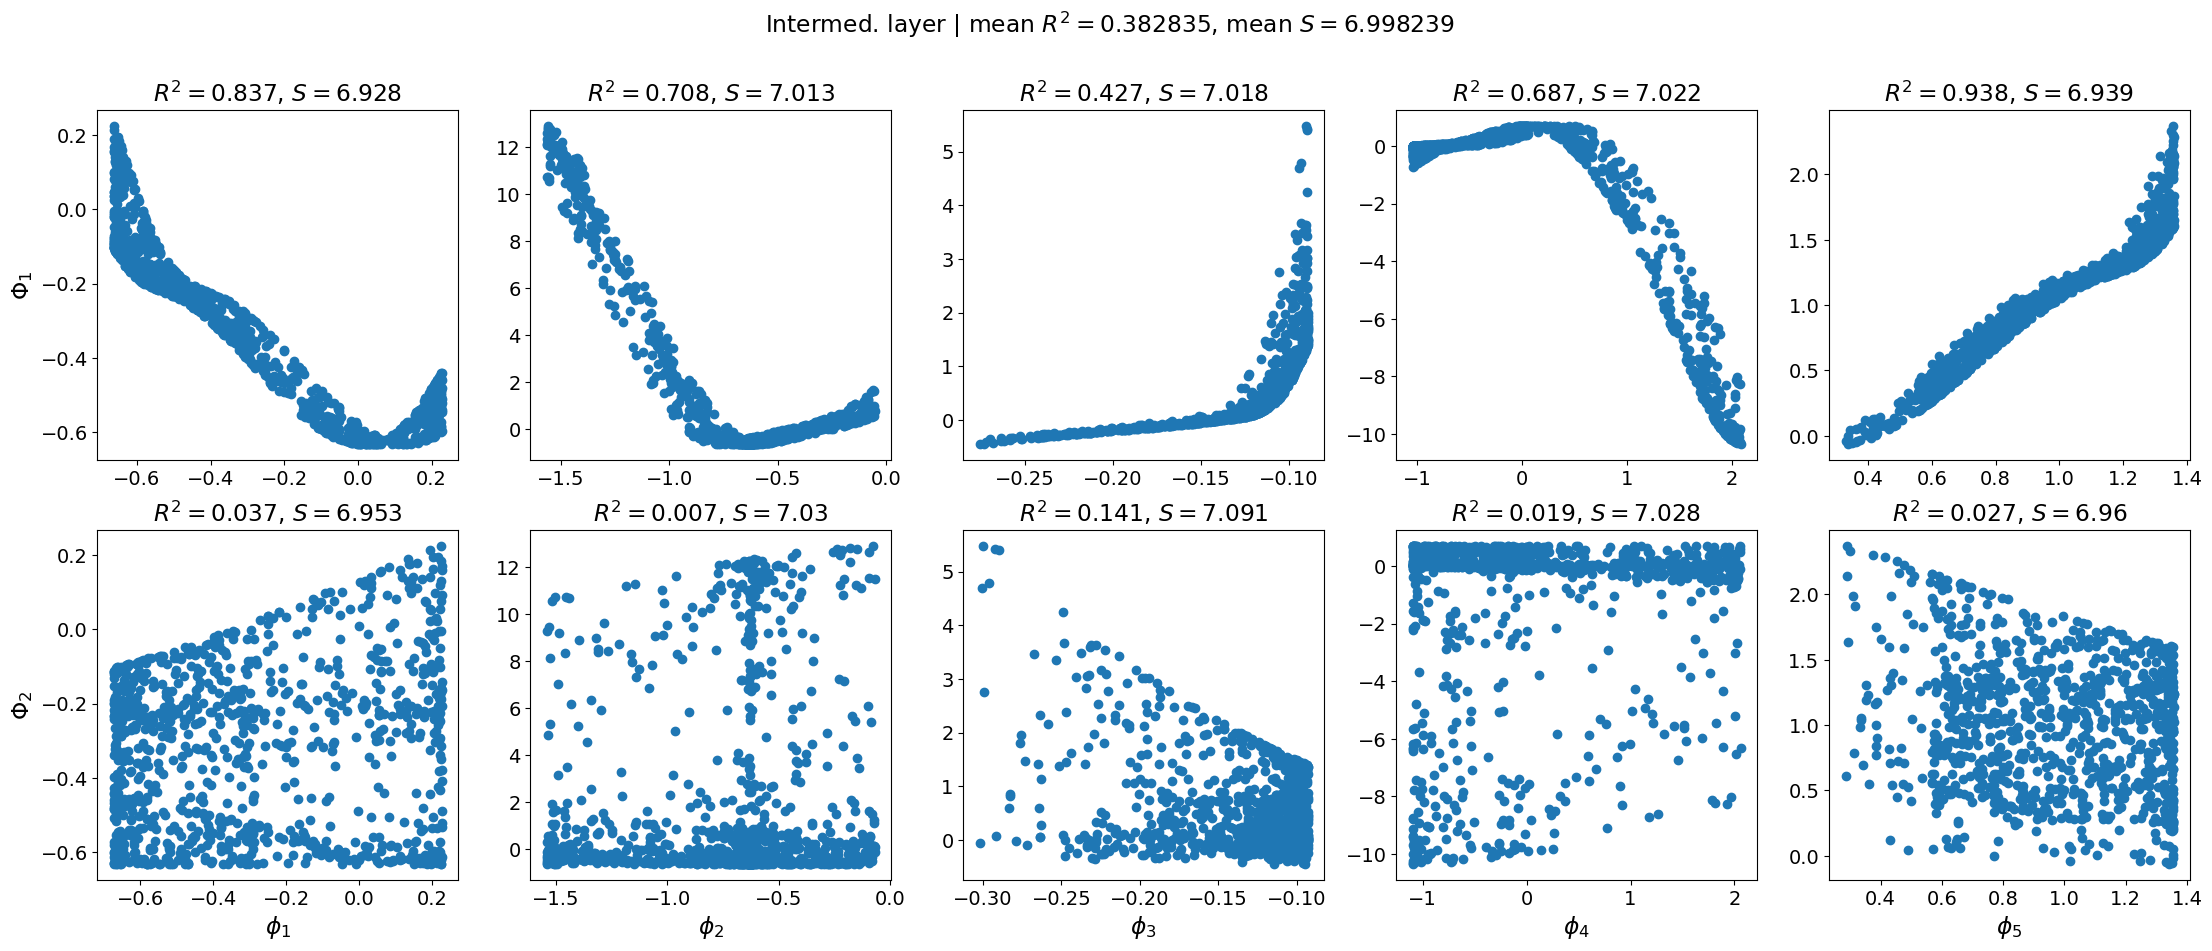

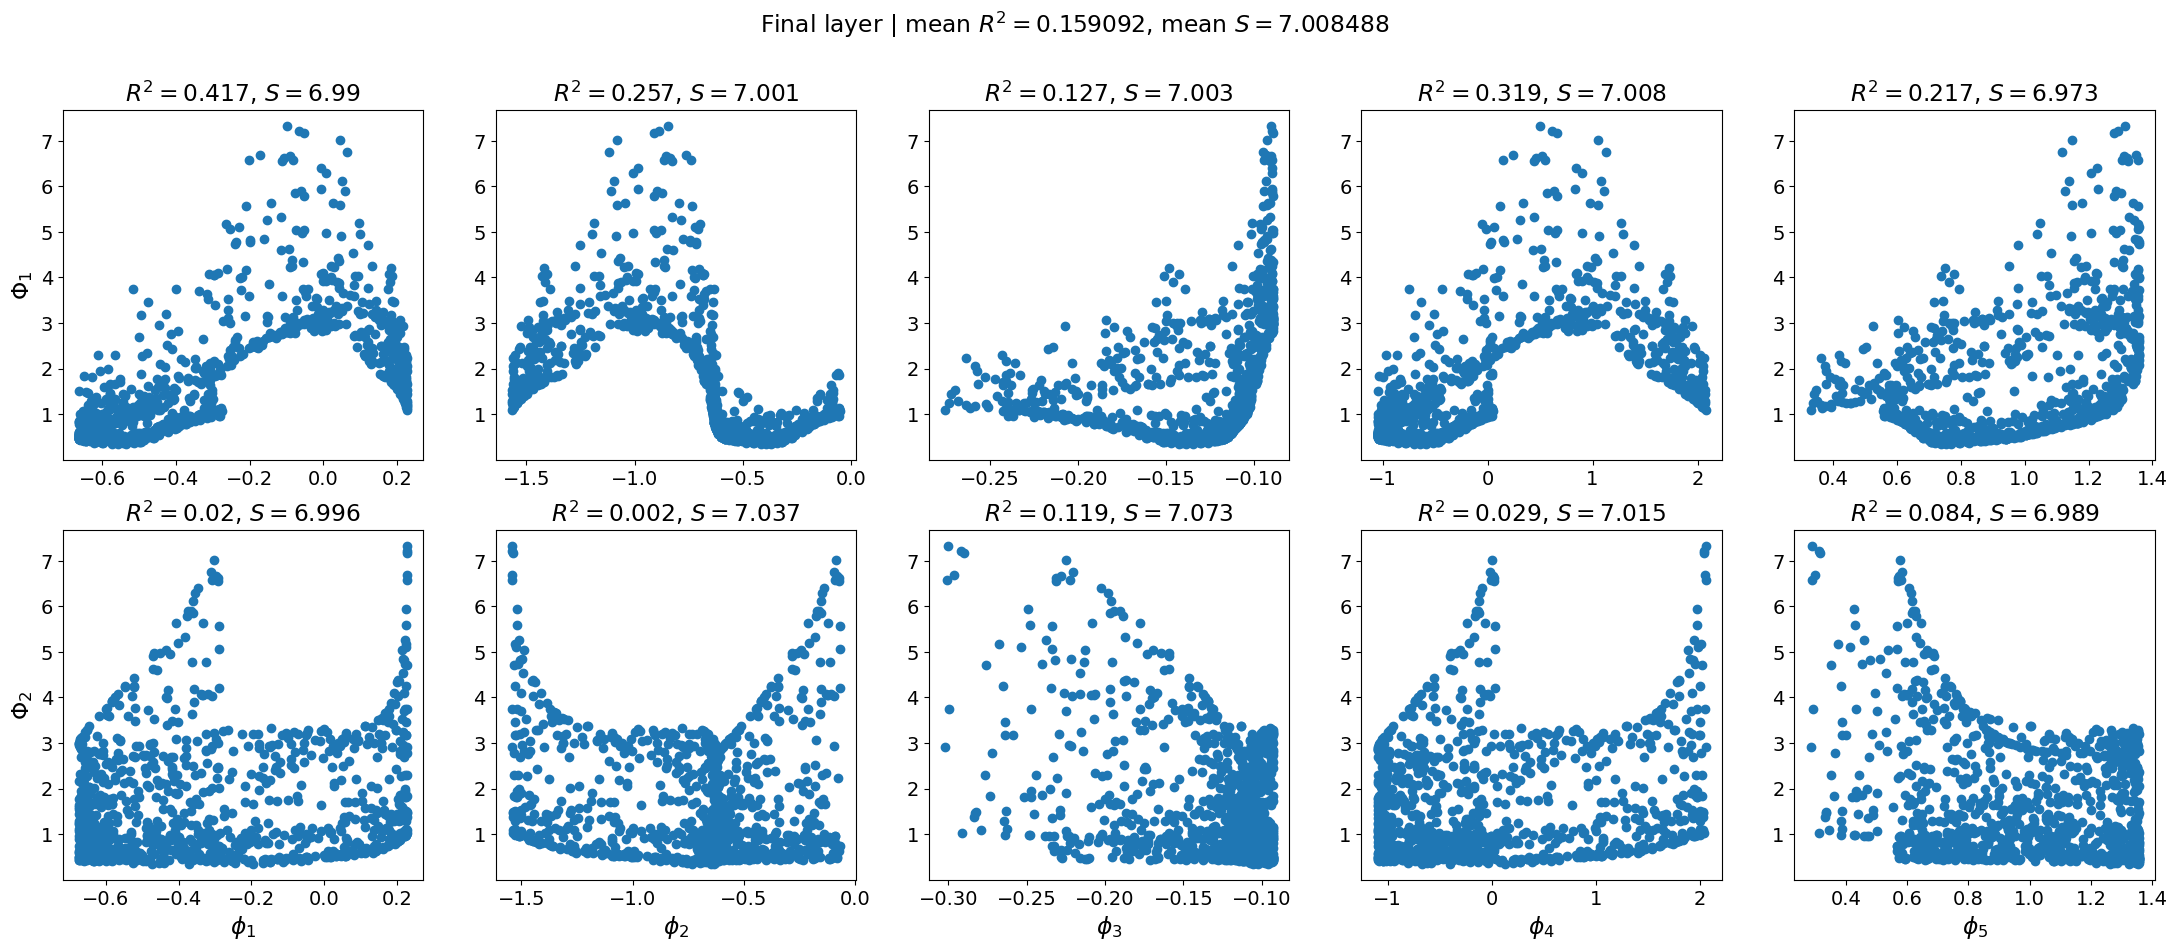

{'mean_r2': 0.15909213051199914, 'mean_matrix_entropy': 7.008487701416016}

In [25]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

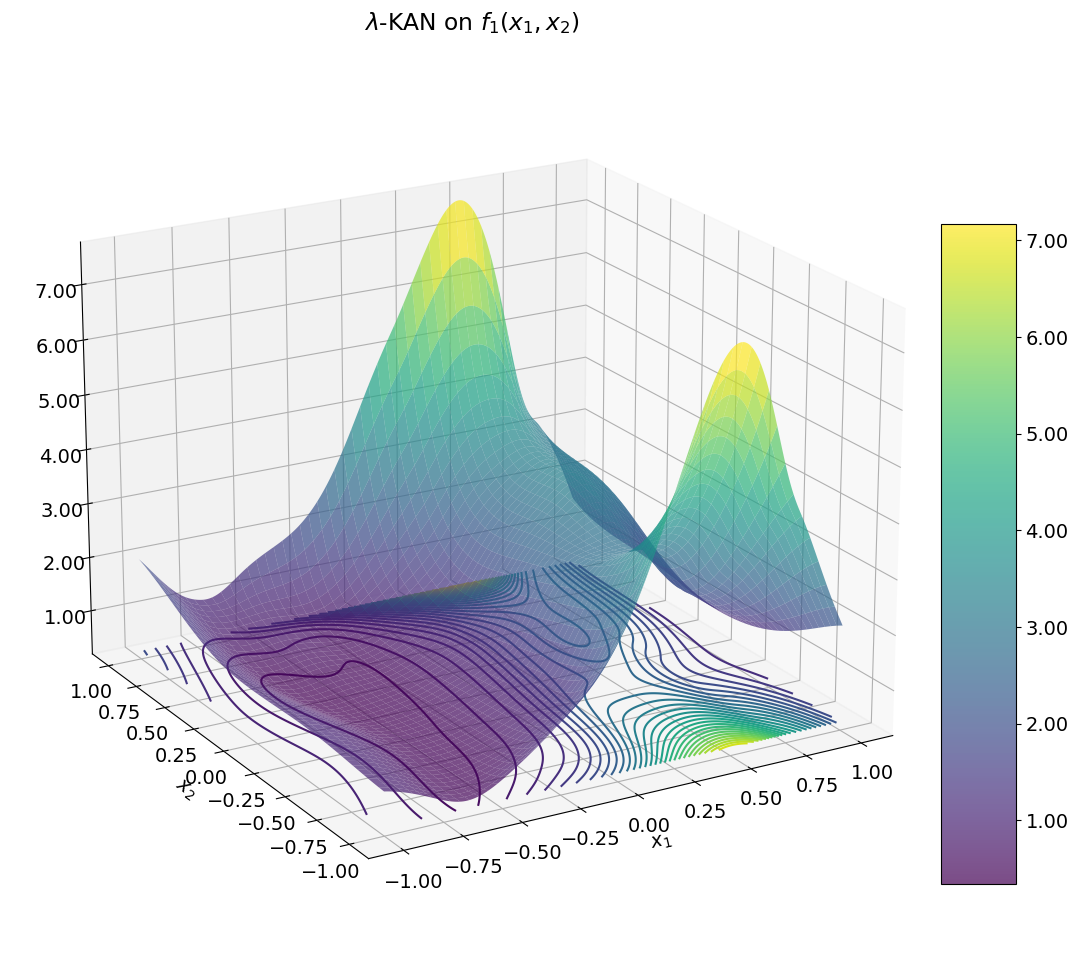

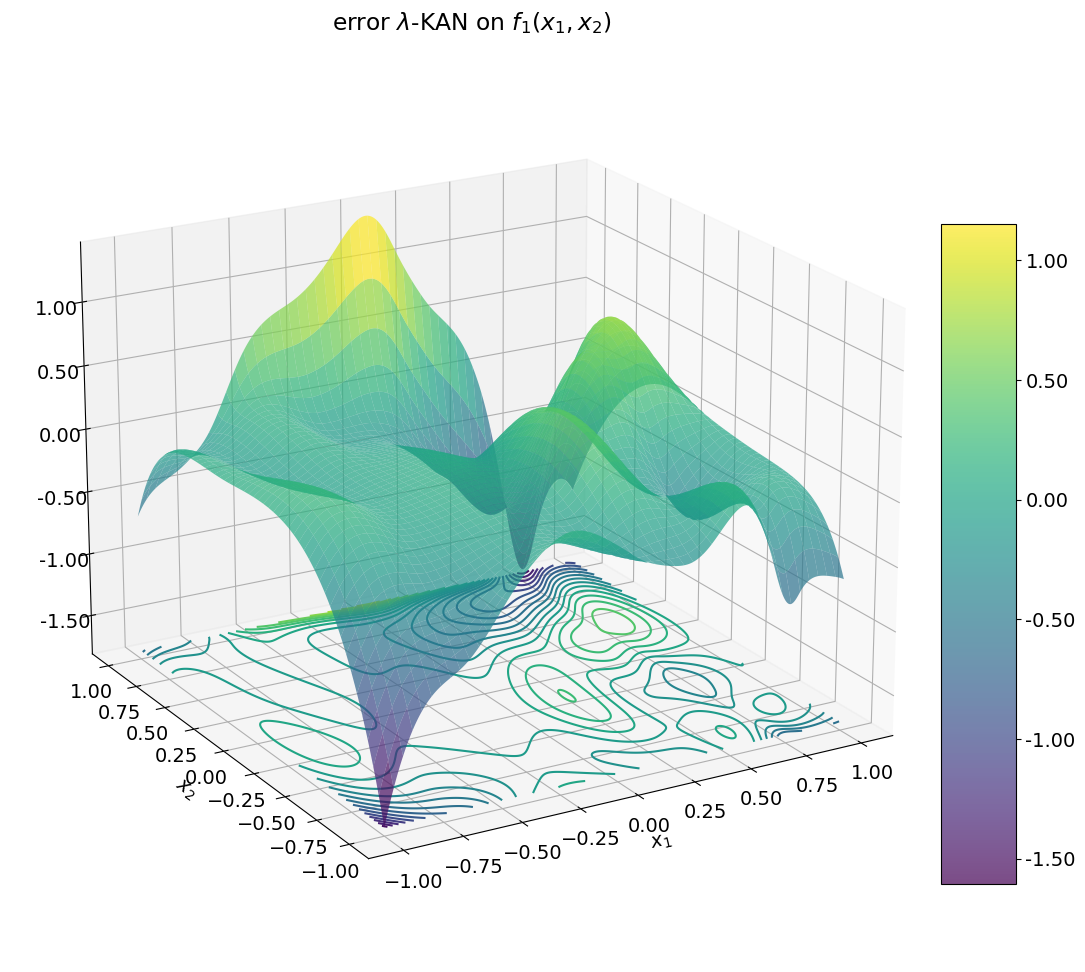

In [26]:
model_plot = lambda x: model(x).detach()
plot_f_3d(model_plot, title='$\lambda$-KAN on $f_1(x_1, x_2)$')

error_model_plot = lambda x: model(x).detach() - f(x)
plot_f_3d(error_model_plot, title='error $\lambda$-KAN on $f_1(x_1, x_2)$')